
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

# Summary:
1. Uploaded a file
2. Aggregated the data on a quarter to quarter sales
3. Did a forecast for each store in relation to last sales' figures
4. Ran linear regression model and checked it's score

Additionally,
5. Incorporated data on population by county
6. Calculated the derivatives by county:
    - Average Bottle Volume per Unit
    - Liquor Consumption per Capita
After the performed analysis, I suggest to use the following model to forecast annual sales on a county-by-county basis:
             Sales2016 = (Sales2015)1.042768 + (AvgBotVol)1,123,697 - (AvgVolCap)*6,917.840 - 90,023.

    Where: Sales2015 - Total sales of stores in a county in 2015. The coefficient reflects average annual expected growth.
           AvgBotVol - average volume of a sold bottle. As you saw during the presentation, visualization allowed to see a certain correlation between the average volume of sold bottle and the population of the county. Thus this would also reflect of forecast of sales in each county.
           
           AvgVolCap - average volume of sold liquors expressed in liters. There is a correlation between the average volume of liquor consumption in each county and its population that affects the expectation of sales. This correlation is negative and reduces the sales expectations almost $7000 for each liter of consumed liquor per capita.

The score is very high, thus giving a hope that given other things remain unchanged this model would work well.
           

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns
plt.style.use('ggplot')
% matplotlib inline
%load_ext giphy_magic
% matplotlib inline
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

## Load the data into a DataFrame
df = pd.read_csv('../../project_2_data/Iowa_Liquor_sales.csv',na_filter = True, low_memory=False)#, infer_datetime_format=True, dtype={‘County Number’:np.int64, ‘Category’: np.int64, 'State Bottle Cost' : np.float64, 'State Bottle Retail' : np.float64, 'Sale (Dollars)' : np.float64}, low_memory = False)
df.head()
# _sample_10pct.csv


The giphy_magic extension is already loaded. To reload it, use:
  %reload_ext giphy_magic


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.5,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.0,0.53
2,03/31/2016,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,$5.97,$8.96,6,$53.76,10.5,2.77
3,03/31/2016,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,$2.24,$3.36,48,$161.28,9.6,2.54
4,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,$12.50,$18.75,6,$112.50,4.5,1.19


# Give it some time to upload

In [61]:
## Transform the dates if needed, e.g.
df.Date = pd.to_datetime(df["Date"], format = "%m/%d/%Y")
#I tried to convert all the dollar amounts into numbers. But was not succesfull to turn the County and Category numbers into integerts
#df['County Number'] = df['County Number'].astype(int)
#df['Category'] = df['Category'].astype(int)
df['State Bottle Cost'] = df['State Bottle Cost'].map(lambda x: str(x)[1:]).astype(float)
df['State Bottle Retail'] = df['State Bottle Retail'].map(lambda x: str(x)[1:]).astype(float)
df['Sale (Dollars)'] = df['Sale (Dollars)'].map(lambda x: str(x)[1:]).astype(float)
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),month,year
0,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,9.99,14.99,12,179.88,4.5,1.19,3,2016
1,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,12.50,18.75,2,37.50,2.0,0.53,3,2016
2,2016-03-31,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,5.97,8.96,6,53.76,10.5,2.77,3,2016
3,2016-03-31,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,2.24,3.36,48,161.28,9.6,2.54,3,2016
4,2016-03-31,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,12.50,18.75,6,112.50,4.5,1.19,3,2016


In [62]:
def eda(dataframe):
    print "missing values \n", dataframe.isnull().sum()
    print "dataframe index \n", dataframe.index
    print "dataframe types \n", dataframe.dtypes
    print "dataframe shape \n", dataframe.shape
    print "dataframe describe \n", dataframe.describe()
    for item in dataframe:
        print item
        print dataframe[item].nunique()

eda(df)

missing values 
Date                         0
Store Number                 0
City                         0
Zip Code                     0
County Number            10913
County                   10913
Category                   779
Category Name             6109
Vendor Number                0
Item Number                  0
Item Description             0
Bottle Volume (ml)           0
State Bottle Cost            0
State Bottle Retail          0
Bottles Sold                 0
Sale (Dollars)               0
Volume Sold (Liters)         0
Volume Sold (Gallons)        0
month                        0
year                         0
dtype: int64
dataframe index 
RangeIndex(start=0, stop=2709552, step=1)
dataframe types 
Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                         object
County Number                   float64
County                           object
Category                        flo

# Let me see, what effect of dropping the lines would be

In [64]:
print 'Total sum of sales with missing category is ---- $', df['Sale (Dollars)'][pd.isnull(df['Category']) == True].sum(), ', that is ', df['Sale (Dollars)'][pd.isnull(df['Category']) == True].sum()/(df['Sale (Dollars)'].sum()), 'of total sales'
print 'Total sum of sales with missing category name is $', df['Sale (Dollars)'][pd.isnull(df['Category Name']) == True].sum(),', that is ', df['Sale (Dollars)'][pd.isnull(df['Category Name']) == True].sum()/(df['Sale (Dollars)'].sum()), 'of total sales'
print 'Total sum of sales with missing County is ------ $', df['Sale (Dollars)'][pd.isnull(df['County']) == True].sum(),', that is ', df['Sale (Dollars)'][pd.isnull(df['Category Name']) == True].sum()/(df['Sale (Dollars)'].sum()), 'of total sales'
print 'While total sales are -------------------------- $', df['Sale (Dollars)'].sum()
dropped_sum = (df['Sale (Dollars)'][pd.isnull(df['Category']) == True].sum() + df['Sale (Dollars)'][pd.isnull(df['Category Name']) == True].sum() + df['Sale (Dollars)'][pd.isnull(df['County']) == True].sum())
print 'Total loss of sales numbers from missing data -- $',dropped_sum, 'That is ', dropped_sum/df['Sale (Dollars)'].sum()


Total sum of sales with missing category is ---- $ 134082.6 , that is  0.000383252010354 of total sales
Total sum of sales with missing category name is $ 1090860.16 , that is  0.00311803581774 of total sales
Total sum of sales with missing County is ------ $ 1231197.66 , that is  0.00311803581774 of total sales
While total sales are -------------------------- $ 349854916.289
Total loss of sales numbers from missing data -- $ 2456140.42 That is  0.00702045421014


In [65]:
# Here I gave another thought and decided to finally drop the missing lines and duplicates
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df.shape

(2689628, 20)

# There is another dataset with population per county that I wanted to incorporate into the dataset

In [66]:
population = pd.read_csv('../../project_2_data/Total_County_Population_by_Year.csv',index_col = 'County', na_filter = True)
population.head()

,Population
County,
Adair,7228
Adams,3796
Allamakee,13886
Appanoose,12529
Audubon,5773


# Below to run once only! - County population is merged with the rest of dataframe

# I know I do it after the presentation and after the submission date. I was not happy with everthing I did. So I am redoing it

In [67]:
df = df.join(population, on = "County", how = "outer")
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),month,year,Population
0,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,...,375,9.99,14.99,12,179.88,4.5,1.19,3,2016,172126
1,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,...,1000,12.50,18.75,2,37.50,2.0,0.53,3,2016,172126
7,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,410,88294,...,375,14.00,21.00,12,252.00,4.5,1.19,3,2016,172126
9,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1052010.0,IMPORTED GRAPE BRANDIES,389,49185,...,375,10.66,15.99,12,191.88,4.5,1.19,3,2016,172126
10,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,410,88296,...,750,27.00,40.50,12,486.00,9.0,2.38,3,2016,172126


# Now let's play with pivot tables.

In [68]:

dfpivot = pd.pivot_table(df, values = ['County','Sale (Dollars)','Bottles Sold', 'Volume Sold (Liters)'], index = ['Store Number'], aggfunc=np.sum)
dfpivot['av_price_unit'] = dfpivot['Sale (Dollars)']/dfpivot['Bottles Sold']
dfpivot['av_vol_unit'] = dfpivot['Volume Sold (Liters)'] / dfpivot['Bottles Sold']
dfpivot['Population'] = df['Population']
dfpivot['County'] = df['County']
dfpivot['liquor_capita'] = dfpivot['Volume Sold (Liters)'] / dfpivot['Population']


dfpivot = pd.DataFrame(dfpivot)
#dfpivot = dfpivot.merge(population, on = 'County', how = 'inner')

dfpivot.head()


,Bottles Sold,Sale (Dollars),Volume Sold (Liters),av_price_unit,av_vol_unit,Population,County,liquor_capita
Store Number,,,,,,,,
2106,123536,1770898.27,116205.17,14.335079,0.940658,7569.0,Worth,15.352777
2113,8184,107426.75,8107.15,13.126436,0.990610,467711.0,Polk,0.017334
2130,92238,1411066.70,83599.13,15.298106,0.906342,467711.0,Polk,0.178741
2152,6675,81350.61,6962.81,12.187357,1.043118,467711.0,Polk,0.014887
2178,24998,336262.73,26271.38,13.451585,1.050939,467711.0,Polk,0.056170


In [69]:
df[(df.Date.dt.quarter == 1) & (df.Date.dt.year == 2015)].groupby('Store Number')

In [70]:
#print '5 counties with top average price per bottle bought \n'
#dfpivot.sort_values('av_price_unit', ascending = False).head()

In [71]:
# print '5 counties with least average price per bottle bought \n'
# dfpivot.sort_values('av_price_unit', ascending = False).tail()

In [72]:
# print '5 counties with top average volume per bottle bought \n'
# dfpivot.sort_values('av_vol_unit', ascending = False).head()

In [73]:
# print '5 counties with least average volume per bottle bought \n'
# dfpivot.sort_values('av_vol_unit', ascending = False).tail()

# Calculate the yearly liquor sales for each store using the provided data. You can add up the transactions for each

# Let's see what summaries we can produce from this set:

In [76]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),month,year,Population
0,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,...,375,9.99,14.99,12,179.88,4.5,1.19,3,2016,172126
1,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,...,1000,12.50,18.75,2,37.50,2.0,0.53,3,2016,172126
7,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,410,88294,...,375,14.00,21.00,12,252.00,4.5,1.19,3,2016,172126
9,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1052010.0,IMPORTED GRAPE BRANDIES,389,49185,...,375,10.66,15.99,12,191.88,4.5,1.19,3,2016,172126
10,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,410,88296,...,750,27.00,40.50,12,486.00,9.0,2.38,3,2016,172126


I grouped the sales by each store for the year 2015


In [82]:
VolumeL = pd.DataFrame({'VolumeL':df.groupby(['Store Number','County','Population'])['Volume Sold (Liters)'].sum()})
Bottles = pd.DataFrame({'Bottles':df.groupby(['Store Number','County','Population'])['Bottles Sold'].sum()})
Sales_Y15Q1 = pd.DataFrame({'Q1Y15':df[(df.Date >= '2015-01-01') & (df.Date < '2015-04-01')].groupby(['Store Number','County', 'Population'])['Sale (Dollars)'].sum()})
Sales_Y15Q2 = pd.DataFrame({'Q2Y15':df[(df.Date >= '2015-04-01') & (df.Date < '2015-07-01')].groupby(['Store Number','County', 'Population'])['Sale (Dollars)'].sum()})
Sales_Y15Q3 = pd.DataFrame({'Q3Y15':df[(df.Date >= '2015-07-01') & (df.Date < '2015-10-01')].groupby(['Store Number','County', 'Population'])['Sale (Dollars)'].sum()})
Sales_Y15Q4 = pd.DataFrame({'Q4Y15':df[(df.Date >= '2015-10-01') & (df.Date < '2016-01-01')].groupby(['Store Number','County', 'Population'])['Sale (Dollars)'].sum()})
Sales_Y16Q1 = pd.DataFrame({'Q1Y16':df[(df.Date >= '2016-01-01') & (df.Date < '2016-04-01')].groupby(['Store Number','County', 'Population'])['Sale (Dollars)'].sum()})
Total_Sales = pd.concat([Bottles, VolumeL ,Sales_Y15Q1, Sales_Y15Q2, Sales_Y15Q3, Sales_Y15Q4, Sales_Y16Q1], axis =1, join = 'outer')

Total_Sales.fillna(0,inplace = True)

Total_Sales.head()
Total_Sales.tail()

,,,Bottles,VolumeL,Q1Y15,Q2Y15,Q3Y15,Q4Y15,Q1Y16
Store Number,County,Population,,,,,,,
9010,Warren,48626,1546,1093.2,11707.62,8010.24,3856.44,2635.08,697.44
9013,Warren,48626,3576,2700.0,825.60,5198.40,4320.36,20613.30,6191.34
9018,Dubuque,97125,900,675.0,0.00,0.00,0.00,21825.00,0.00
9022,Scott,172126,252,189.0,3992.10,0.00,0.00,0.00,651.42
9023,Carroll,20498,372,279.0,5383.56,633.36,1900.08,633.36,1266.72


In [80]:
# print Total_Sales.Q1Y16.sort_values(ascending = False).head()
# print 'Total Sales in Q1Y16 $', Total_Sales.Q1Y16.sort_values(ascending = False).sum()

# REVISED:
I will:
1. Group the Total_Sales by Counties now,
2. Add average bottle volume
3. Average vol / capita 
And build model based on 4 variables: 3 above and Q1Y15 sales.
Q1Y16 is predicted value.

In [102]:
VolumeL = pd.DataFrame({'VolumeL':df.groupby(['County','Population'])['Volume Sold (Liters)'].sum()})
Bottles = pd.DataFrame({'Bottles':df.groupby(['County','Population'])['Bottles Sold'].sum()})
Sales_Y15Q1 = pd.DataFrame({'Q1Y15':df[(df.Date >= '2015-01-01') & (df.Date < '2015-04-01')].groupby(['County', 'Population'])['Sale (Dollars)'].sum()})
Sales_Y15Q2 = pd.DataFrame({'Q2Y15':df[(df.Date >= '2015-04-01') & (df.Date < '2015-07-01')].groupby(['County', 'Population'])['Sale (Dollars)'].sum()})
Sales_Y15Q3 = pd.DataFrame({'Q3Y15':df[(df.Date >= '2015-07-01') & (df.Date < '2015-10-01')].groupby(['County', 'Population'])['Sale (Dollars)'].sum()})
Sales_Y15Q4 = pd.DataFrame({'Q4Y15':df[(df.Date >= '2015-10-01') & (df.Date < '2016-01-01')].groupby(['County', 'Population'])['Sale (Dollars)'].sum()})
Sales_Y16Q1 = pd.DataFrame({'Q1Y16':df[(df.Date >= '2016-01-01') & (df.Date < '2016-04-01')].groupby(['County', 'Population'])['Sale (Dollars)'].sum()})
County_Sales = pd.concat([Bottles, VolumeL ,Sales_Y15Q1, Sales_Y15Q2, Sales_Y15Q3, Sales_Y15Q4, Sales_Y16Q1], axis =1, join = 'outer')
County_Sales.reset_index(level = 1, inplace = True)
County_Sales['AvgBotVol'] = County_Sales.VolumeL / County_Sales.Bottles
County_Sales['AvgVolCap'] = County_Sales.VolumeL / County_Sales['Population']

County_Sales.head()

,Population,Bottles,VolumeL,Q1Y15,Q2Y15,Q3Y15,Q4Y15,Q1Y16,AvgBotVol,AvgVolCap
County,,,,,,,,,,
Adair,7228,43274,41984.04,103556.31,101055.72,97826.02,119477.03,105206.47,0.970191,5.808528
Adams,3796,10173,9191.49,20335.03,24084.16,24957.83,31219.78,21834.49,0.903518,2.421362
Allamakee,13886,74483,81016.16,155988.96,237567.36,212792.43,216994.85,178497.55,1.087713,5.834377
Appanoose,12529,81446,75076.65,151755.48,225956.02,223354.82,231894.64,176583.49,0.921797,5.992230
Audubon,5773,18552,18283.05,39274.46,42301.65,41480.62,50792.50,37113.57,0.985503,3.166993


In [104]:
print Total_Sales.sum()
k = Total_Sales.Q1Y16.sum()/Total_Sales.Q1Y15.sum()
print 'YoY increment from 2015 to 2016:', k
Q2Y16 = Total_Sales.Q2Y15.sum()*Total_Sales.Q1Y16.sum()/Total_Sales.Q1Y15.sum()
print 'Forecast of sales for Q2 Y16: $', Q2Y16
FY16 = Total_Sales.Q3Y15.sum() + Total_Sales.Q4Y15.sum() + Total_Sales.Q1Y16.sum() + Q2Y16
print 'Thus the forecast fot the fiscal year 2016: $', FY16

Bottles    26469056.00
VolumeL    24022727.73
Q1Y15      62871966.56
Q2Y15      72227424.14
Q3Y15      68437351.23
Q4Y15      79992237.88
Q1Y16      63559801.94
dtype: float64
YoY increment from 2015 to 2016: 1.01094025553
Forecast of sales for Q2 Y16: $ 73017610.6165
Thus the forecast fot the fiscal year 2016: $ 285007001.667


<b>Preliminary result:</b>
The forecast amount of sales in FY2016 - <i>USD289,790,002</i> vs real <i>USD288,908,790</i>

Difference of <i>$881,211</i>, that's 1.2 percent error

For annual reports please click here - https://abd.iowa.gov/annual-reports

# <b>Now let me try to run the linear regression on the dataframe with just quarterly sales to predict sales of each store in Q2Y16</b>

In [122]:
# For forecasting I will be using the per store sales 
# Let's see the shape of the Working_Stores
print County_Sales.shape
County_Sales.head()

(99, 10)


,Population,Bottles,VolumeL,Q1Y15,Q2Y15,Q3Y15,Q4Y15,Q1Y16,AvgBotVol,AvgVolCap
County,,,,,,,,,,
Adair,7228,43274,41984.04,103556.31,101055.72,97826.02,119477.03,105206.47,0.970191,5.808528
Adams,3796,10173,9191.49,20335.03,24084.16,24957.83,31219.78,21834.49,0.903518,2.421362
Allamakee,13886,74483,81016.16,155988.96,237567.36,212792.43,216994.85,178497.55,1.087713,5.834377
Appanoose,12529,81446,75076.65,151755.48,225956.02,223354.82,231894.64,176583.49,0.921797,5.992230
Audubon,5773,18552,18283.05,39274.46,42301.65,41480.62,50792.50,37113.57,0.985503,3.166993


In [124]:
y = County_Sales.Q1Y16
X = County_Sales[['Q1Y15', 'AvgBotVol', 'AvgVolCap']]
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(69, 3) (69,)
(30, 3) (30,)


In [127]:
# fit a model
lm = linear_model.LinearRegression()
print lm
model = lm.fit(X_train, y_train)
print model
predictions = lm.predict(X_test)
print predictions
print X_train.shape
print y_train.shape

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
[  318068.729297     940286.62361269    85028.48380351   730801.74170019
   393728.0604912    559565.25404053    22967.30168787   572286.22883317
    40473.61685455   268988.81735391    66712.12110229   251106.38017922
   114252.07133815   394436.75208799    69427.67229687    73874.05886464
   289211.26549601   189687.16161172   367400.94777942   273819.89388181
  2078756.32005038   378931.01690837   112017.2137892    209655.61071155
   268837.17947224   116849.57064124    83227.91680075    57688.15336567
   339690.12738884   175386.56658548]
(69, 3)
(69,)


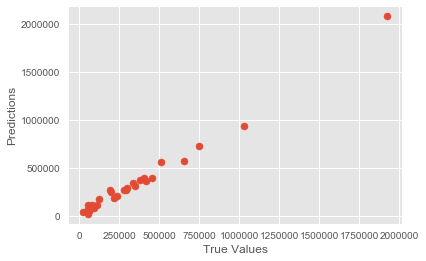

In [128]:
#validate the model on the cv = k-1
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

# So here are the results and the model is:

In [130]:
print "Score:", model.score(X_test, y_test)  
print 'Model coefficient is:', lm.coef_
print lm.intercept_
print 'Based on multilinear regression, the forecast for fiscal year 2016 is $'


Score: 0.983682361475
Model coefficient is: [  1.04276821e+00   1.12369750e+05  -6.91783957e+03]
-90023.3226206
Based on multilinear regression, the forecast for fiscal year 2016 is $


# Thus, the MLR looks like this:
# Sales2016 = (Sales2015)*1.042768 + (AvgBotVol)*1,123,697 - (AvgVolCap)*6,917.840 - 90,023.
# Let's try to apply for each county

In [132]:
County_Sales['FY2016'] = (County_Sales.Q1Y15+County_Sales.Q2Y15+County_Sales.Q3Y15+County_Sales.Q4Y15)*lm.coef_[0]+County_Sales.AvgBotVol*lm.coef_[1]+County_Sales.AvgVolCap*lm.coef_[2]+lm.intercept_
County_Sales.head()
County_Sales.FY2016.sum()

293757138.3062415

# The Final Part - Regularization

In [111]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [133]:
# Perform 6-fold cross validation
print County_Sales.shape
scores = cross_val_score(lm, X_train, y_train, cv=6)
print "Cross-validated scores:", scores
print "Average: ", scores.mean()

(99, 11)
Cross-validated scores: [ 0.99063451  0.99327417  0.99704742  0.99688722  0.99812326  0.99882262]
Average:  0.995798202145


In [134]:
# LASSO regression

# Let me play with alpha = 0.01

In [135]:
# try alpha=0.01 and examine coefficients
from sklearn.linear_model import Lasso
lassoreg = Lasso(alpha=0.01, normalize=True)
lassoreg.fit(X_train, y_train)
print lassoreg.coef_

[  1.04276803e+00   1.12367352e+05  -6.91773777e+03]


In [136]:
# calculate MSE (for alpha=0.01)
y_pred = lassoreg.predict(X_test)
print np.sqrt(metrics.mean_squared_error(y_test, y_pred))

48080.7837785


In [ ]:
# Not bad. Now I am happier.

# I hope I am done. I am happier with the current results. I would present this model, if I had to.